In [34]:
# example_meta_data_
# reader.ipynb
# Authors: Stephan Meighen-Berger
# Shows how to deal with the output files

In [35]:
import awkward as ak
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import json
%matplotlib widget
# %matplotlib qt

In [21]:
# Example loading a directory (highly recommend using lazy loading)
example_set = ak.from_parquet('./output/3_photons.parquet')

In [22]:
meta = pq.read_metadata('./output/3_photons.parquet').metadata[b'config_prometheus']
jmeta = json.loads(meta)
jmeta['general']

{'version': 'github'}

In [23]:
jmeta['injection']

{'name': 'LeptonInjector',
 'LeptonInjector': {'inject': True,
  'paths': {'install location': '/opt/LI/install/lib/python3.9/site-packages',
   'xsec dir': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/resources/cross_section_splines/',
   'earth model location': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/resources/earthparams/densities/PREM_arca.dat',
   'injection file': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/examples/output/3_LI_output.h5',
   'lic file': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/examples/output/3_LI_config.lic',
   'diff xsec': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/resources/cross_section_splines/dsdxdy_nubar_CC_iso.fits',
   'total xsec': '/home/unimelb.edu.au/smeighenberg/Projects/prometheus/resources/cross_section_splines/sigma_nubar_CC_iso.fits'},
  'simulation': {'final state 1': 'MuMinus',
   'final state 2': 'Hadrons',
   'minimal energy': 1000.0,
   'maximal energy': 10000.0,
   'power law'

In [24]:
# Example loading a single file
# example_set = ak.from_parquet('./output/custom_1337_meta_data.parquet')

In [25]:
# The events are split into three parts:
#   - lepton: the light from the generated lepton
#   - hadron: the light produced from the associated hadronic cascade (at production point)
#   - total: the light from both parts
# Each of these fields is formatted the same way
example_set.fields

['mc_truth', 'photons']

In [26]:
# Example for one event
event_id = 0
# The sensors hit
print("Total number of hits:")
print(len(example_set.photons.sensor_id[event_id]))
print('The hit sensors: ')
print(example_set.photons.sensor_id[event_id])
print('Their associated strings')
print(example_set.photons.string_id[event_id])
print('The hit times')
print(example_set.photons.t[event_id])

Total number of hits:
2566
The hit sensors: 
[16, 10, 10, 13, 16, 16, 14, 15, 9, 12, ..., 14, 15, 15, 16, 17, 17, 17, 16, 12]
Their associated strings
[67, 76, 76, 76, 76, 77, 80, 86, ..., 108, 108, 108, 108, 108, 108, 111, 112]
The hit times
[1.24e+03, 1.4e+03, 1.31e+03, 988, 892, ..., 521, 554, 684, 867, 1.52e+03]


In [27]:
example_set.photons.sensor_pos_x

<Array [[61.2, 139, 139, ..., 390, 440, 447], ...] type='10 * var * float64'>

In [28]:
def parquet_sub_plotting(
        data, e_id, det,
        channel='photons',
        scaling=20,
        number_of_hits=1000,
        hitcut=3,
        offset=0
    ):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hit_counts = []
    print(len(data[channel].sensor_pos_x[e_id])-1)
    subset_ids = np.random.randint(
        0,
        len(data[channel].sensor_pos_x[e_id])-1,
        size=number_of_hits
    )
    print('Total amount of hits: %d' %len(data[channel].sensor_pos_x[e_id]))
    print('Using a subset of %d for plotting' %number_of_hits)
    event_id = e_id
    sensor_comb = np.array([
        [data[channel].sensor_pos_x[event_id][subset_ids][i],
        data[channel].sensor_pos_y[event_id][subset_ids][i],
        data[channel].sensor_pos_z[event_id][subset_ids][i]
        ]
        for i in range(number_of_hits)
    ])
    print('Fetching unique modules and their hits')
    hit_doms, hit_counts = np.unique(sensor_comb, axis=0, return_counts=True)
    print('Number of hit doms: %d' %len(hit_doms))
    hit_counts = np.log10(hit_counts)
    hit_counts[hit_counts < np.log10(hitcut)] = 0.
    print('Finished the modules')
    print('Plotting...')
    ax.scatter(
        hit_doms[:, 0],
        hit_doms[:, 1],
        hit_doms[:, 2]+offset,
        s=(
            hit_counts * scaling
        ),
        color='r', alpha=0.5)
    print('Finished modules')
    ax.scatter(
        det[:, 0],
        det[:, 1],
        det[:, 2]+offset,
        s=1,
        color='k', alpha=0.5)
    # ax.set_xlim(min(det[:, 0]), max(det[:, 0]))
    # ax.set_ylim(min(det[:, 1]), max(det[:, 1]))
    # ax.set_zlim(min(det[:, 2]), max(det[:, 2]))
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    plt.title(
        'Event %d with pdg id = %d and energy %.1f GeV' % (
            event_id,
            data.mc_truth.final_state_type[event_id][0],
            data.mc_truth.final_state_energy[event_id][0]
            )
    )
    plt.show()

In [29]:
# Getting the detector
pos = []
with open('../resources/geofiles/arca.geo') as geo_in:
    read_lines = geo_in.readlines()
    modules_i = read_lines.index("### Modules ###\n")   
    for line in read_lines[modules_i+1:]:
        line = line.strip("\n").split("\t")
        pos.append(
            np.array([float(line[0]), float(line[1]),
            float(line[2])]))
    det = np.array(pos)
det = det#  - np.mean(det, axis=0)

342
Total amount of hits: 343
Using a subset of 1000 for plotting
Fetching unique modules and their hits
Number of hit doms: 37
Finished the modules
Plotting...
Finished modules


/tmp/ipykernel_2687/127794781.py:32: RuntimeWarning: divide by zero encountered in log10
  hit_counts[hit_counts < np.log10(hitcut)] = 0.


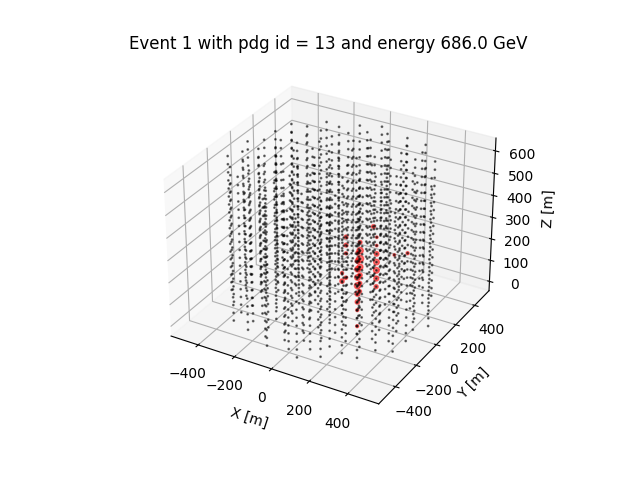

In [32]:
parquet_sub_plotting(
    example_set,
    e_id=1, det=det,
    channel='photons',
    scaling=10,
    number_of_hits=1000,
    hitcut=0,
    offset=3500
)

In [33]:
import sys
sys.path.append('../')
from prometheus.plotting import plot_brightest

ModuleNotFoundError: No module named 'proposal'